In [1]:
#https://github.com/chris-stellato/capstone3/tree/main/notebooks


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import math
import random
import os
import time
from tensorflow import keras

In [3]:
convert_to_dt = ['Date']

data = pd.read_csv('C:/Users/tomwr/Datasets/Tabular/tesco-stock.csv',
                   parse_dates = convert_to_dt,
                   infer_datetime_format = True
                  )
data_normal_index = data
data_date = data.set_index('Date')
print(data.head())
print()
print(data.info())

        Date        Open        High         Low       Close   Adj Close  \
0 2021-09-20  254.850006  255.751007  252.050003  254.449997  244.151596   
1 2021-09-21  255.550003  257.850006  254.750000  257.200012  246.790314   
2 2021-09-22  258.750000  261.649994  258.049988  261.649994  251.060181   
3 2021-09-23  263.500000  264.520996  259.500000  259.549988  249.045166   
4 2021-09-24  260.100006  260.500000  257.500000  257.500000  247.078156   

     Volume  
0  13732928  
1  18373464  
2  15194454  
3  13317828  
4   9898053  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Open       252 non-null    float64       
 2   High       252 non-null    float64       
 3   Low        252 non-null    float64       
 4   Close      252 non-null    float64       
 5   Adj Close  252 non-n

In [4]:
#windowize function, three dimensional output for X and y, split afterwards
#the below windowize functions are imported but pasted here for working through setup
def windowize_data(data, n_prev, y_var, predict_steps=365):
    n_predictions = len(data) - n_prev
    
    print(f'num_predictions: {n_predictions}')
    y = data[y_var].iloc[n_prev:].values
    y_indices = np.arange(predict_steps) + np.arange(len(y) - predict_steps+1)[:, None] # (0 to 365) + (
    y = y[y_indices]
    x_indices = np.arange(n_prev) + np.arange(n_predictions- predict_steps+1)[:, None]
    x = data.values[x_indices]
    return x, y

In [5]:
n_prev = 25 # days behind
n_forecast = 10 # days forecast ahead

X, y = windowize_data(data, n_prev, 'Close', n_forecast)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

num_predictions: 227
X shape: (218, 25, 7)
y shape: (218, 10)


In [6]:
WINDOW_SIZE = 10 #30
FORECAST_LEN = 5 #10

def windowize_data2(data, window_size, forecast_len, target):
    target_col = data[target]
    X = []
    y = []
    data_np = data.to_numpy()
    
    for i in range(len(data) - window_size): # for i in range (252 - 25 = 227)
        current_row_index = i - 1
        
        features = [[a] for a in data_np[i : i + window_size]] # row for row in data_numpy[1 : 1 + window_size]
        X.append(features)
        
        #labels = [[b] for b in target_col.iloc[i: i + window_size] in data[i: i + forecast_len]]
        
        #Labels need to be arrays for the next forecast_len values of data[target_col] for each row in data
        
        
        #y.append(labels)
        
    return np.array(X), np.array(y)

X2, y2 = windowize_data2(data_date, WINDOW_SIZE, FORECAST_LEN, 'Close')

In [7]:
print(X2.shape)
print(y2.shape)

(242, 10, 1, 6)
(0,)


In [8]:
print(data_date.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-09-20 to 2022-09-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB
None


In [9]:
#https://www.kaggle.com/code/rinichristy/bi-uni-lstm-rnns-for-temperature-forecasting
#assumes data has been scaled before this stage
def windowize_data3(data, window_size, forecast_len):
    X3 = []
    y3 = []
    for i in range(len(data) - window_size - forecast_len):
        X3.append(data[i: (i + window_size)])
        #y3.append(data[:, -1][i + window_size: i + window_size + forecast_len])
        
        y3.append(data[: -1][i + window_size: i + window_size + forecast_len])

    X3 = np.array(X3) #
    y3 = np.array(y3) #
    ry3 = y3[:, :, 3] # selects the 3rd index (Close) - our target
    
    return np.array(X3), np.array(y3), np.array(ry3)

X3, y3, ry3 = windowize_data3(data_date, WINDOW_SIZE, FORECAST_LEN)

#print(X3.shape)
print(f'y3 shape: {y3.shape}') # Needs to be (212, 10) - 212 samples of the next 10 values of close.
print()
print()
print(f'ry3 shape: {ry3.shape}')
print()
print()
print(f'X3 shape: {X3.shape}')

#https://stackoverflow.com/questions/52572391/extract-nth-value-from-3d-array (for below)


y3 shape: (237, 5, 6)


ry3 shape: (237, 5)


X3 shape: (237, 10, 6)


In [10]:
print(X3[0])

#10 rows as windowsize = 10. 
#6 values in each as these are the columns.

[[2.54850006e+02 2.55751007e+02 2.52050003e+02 2.54449997e+02
  2.44151596e+02 1.37329280e+07]
 [2.55550003e+02 2.57850006e+02 2.54750000e+02 2.57200012e+02
  2.46790314e+02 1.83734640e+07]
 [2.58750000e+02 2.61649994e+02 2.58049988e+02 2.61649994e+02
  2.51060181e+02 1.51944540e+07]
 [2.63500000e+02 2.64520996e+02 2.59500000e+02 2.59549988e+02
  2.49045166e+02 1.33178280e+07]
 [2.60100006e+02 2.60500000e+02 2.57500000e+02 2.57500000e+02
  2.47078156e+02 9.89805300e+06]
 [2.58899994e+02 2.59950012e+02 2.57100006e+02 2.57899994e+02
  2.47461960e+02 1.60735510e+07]
 [2.56899994e+02 2.59000000e+02 2.54399994e+02 2.56350006e+02
  2.45974701e+02 1.45675030e+07]
 [2.56950012e+02 2.58899994e+02 2.56100006e+02 2.56500000e+02
  2.46118637e+02 2.43726390e+07]
 [2.58000000e+02 2.58700012e+02 2.52800003e+02 2.53300003e+02
  2.43048141e+02 2.52676980e+07]
 [2.51199997e+02 2.51600006e+02 2.46600006e+02 2.47949997e+02
  2.37914673e+02 2.41409030e+07]]


In [11]:
print(ry3[0])

#1 row = 1 row of outputs
#5 values in row = next 5 values of close.

[251.649994 253.       268.049988 273.149994 275.600006]


**Split data into train, val, test - 80: 10: 10**

In [12]:
print(len(X3))
print(len(ry3))
print()
print(f'80% of dataset: {(len(X3) / 100) * 80}')
print(f'90% of dataset: {(len(X3) / 100) * 90}')

X_train, y_train = X3[:190], ry3[:190]
X_val, y_val = X3[190: 214], ry3[190:214]
X_test, y_test = X3[214:], ry3[214:]

print()
print(f'X_train, y_train shapes: {X_train.shape, y_train.shape}')
print(f'X_val, y_val shapes: {X_val.shape, y_val.shape}')
print(f'X_test, y_test shapes: {X_test.shape, y_test.shape}')

237
237

80% of dataset: 189.60000000000002
90% of dataset: 213.3

X_train, y_train shapes: ((190, 10, 6), (190, 5))
X_val, y_val shapes: ((24, 10, 6), (24, 5))
X_test, y_test shapes: ((23, 10, 6), (23, 5))


In [13]:
from keras.models import Sequential
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.losses import *
from keras.metrics import *
from keras.constraints import *

In [14]:
#This works but performs poorly on unscaled data. 

lstm_1 = Sequential([
    LSTM(units = 64, input_shape = X3.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Dense(units = FORECAST_LEN, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_1.compile(loss = 'mean_squared_error',
               optimizer = Adam(),
               metrics = RootMeanSquaredError()
              )

lstm_1_history = lstm_1.fit(X_train, y_train,
                            validation_data = (X_val, y_val),
                            epochs = 5
                           )


Epoch 1/5
6/6 [==============================] - 5s 221ms/step - loss: 74664.8125 - root_mean_squared_error: 273.2486 - val_loss: 66361.6484 - val_root_mean_squared_error: 257.6075
Epoch 2/5
6/6 [==============================] - 0s 16ms/step - loss: 74041.3594 - root_mean_squared_error: 272.1054 - val_loss: 66095.9844 - val_root_mean_squared_error: 257.0914
Epoch 3/5
6/6 [==============================] - 0s 15ms/step - loss: 73772.6094 - root_mean_squared_error: 271.6111 - val_loss: 65856.1328 - val_root_mean_squared_error: 256.6245
Epoch 4/5
6/6 [==============================] - 0s 14ms/step - loss: 73527.5078 - root_mean_squared_error: 271.1596 - val_loss: 65632.3438 - val_root_mean_squared_error: 256.1881
Epoch 5/5
6/6 [==============================] - 0s 13ms/step - loss: 73295.0703 - root_mean_squared_error: 270.7306 - val_loss: 65417.1523 - val_root_mean_squared_error: 255.7678


In [15]:
lstm_1_predictions = lstm_1.predict(X_test)

print(len(lstm_1_predictions))
print()
print(lstm_1_predictions)

#Each row in predictions of all 4 is days +1, +2, +3 etc. 

1/1 [==============================] - 1s 828ms/step
23

[[6.4790645 5.720898  6.1368933 5.3759356 5.7756815]
 [6.4790645 5.720898  6.1368933 5.3759356 5.7756815]
 [6.479064  5.720898  6.1368933 5.3759356 5.7756815]
 [6.479064  5.720898  6.1368933 5.3759356 5.7756815]
 [6.4790645 5.720898  6.1368933 5.3759356 5.7756815]
 [6.479064  5.720898  6.1368933 5.3759356 5.7756815]
 [6.479064  5.720898  6.1368933 5.3759356 5.7756815]
 [6.4790645 5.720898  6.1368933 5.3759356 5.7756815]
 [6.479064  5.720898  6.1368933 5.3759356 5.7756815]
 [6.479064  5.720898  6.1368933 5.3759356 5.7756815]
 [6.4790645 5.720898  6.1368933 5.3759356 5.7756815]
 [6.479064  5.720898  6.1368933 5.3759356 5.7756815]
 [6.479064  5.720898  6.1368933 5.3759356 5.7756815]
 [6.4790645 5.720898  6.1368933 5.3759356 5.7756815]
 [6.4790645 5.720898  6.1368933 5.3759356 5.7756815]
 [6.4790645 5.720898  6.1368933 5.3759356 5.7756815]
 [6.4790645 5.720898  6.1368933 5.3759356 5.7756815]
 [6.4790645 5.720898  6.1368933 5.3759356 

**Scaling the data for better performance (hopefully)**

In [43]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler(feature_range = (0, 1))


label_scaler = MinMaxScaler(feature_range = (0, 1))

################## FEATURES ###########################
#Break down arrays shapes
X_train_sequences, X_train_window, X_train_features = X_train.shape
X_val_sequences, X_val_window, X_val_features = X_val.shape
X_test_sequences, X_test_window, X_test_features = X_test.shape

#Create 2D versions - so can be transformed
X_train_2D = X_train.reshape(X_train_sequences, X_train_window * X_train_features)
X_val_2D = X_val.reshape(X_val_sequences, X_val_window * X_val_features)
X_test_2D = X_test.reshape(X_test_sequences, X_test_window * X_test_features)

#Create 2D scaled versions
X_train_2D_scaled = feature_scaler.fit_transform(X_train_2D)
X_val_2D_scaled = feature_scaler.transform(X_val_2D)
X_test_2D_scaled = feature_scaler.transform(X_test_2D)

#Create 3D scaled versions - so can be used in a model
X_train_3D_scaled = X_train_2D_scaled.reshape(X_train_sequences, X_train_window, X_train_features)
X_val_3D_scaled = X_val_2D_scaled.reshape(X_val_sequences, X_val_window, X_val_features)
X_test_3D_scaled = X_test_2D_scaled.reshape(X_test_sequences, X_test_window, X_test_features)

################## LABELS ##############################

#Create scaled 2D labels - y_train is already 2D
y_train_2D_scaled = label_scaler.fit_transform(y_train)
y_val_2D_scaled = label_scaler.transform(y_val)
y_test_2D_scaled = label_scaler.transform(y_test)

#Create scaled 1D labels
y_train_1D_scaled = y_train_2D_scaled.flatten()
y_val_1D_scaled = y_val_2D_scaled.flatten()
y_test_1D_scaled = y_test_2D_scaled.flatten()

#Create unscaled 1D labels
y_train_1D_unscaled = label_scaler.inverse_transform(y_train_2D_scaled).flatten()
y_val_1D_unscaled = label_scaler.inverse_transform(y_val_2D_scaled).flatten()
y_test_1D_unscaled = label_scaler.inverse_transform(y_test_2D_scaled).flatten()

#Create unscaled 2D labels
y_train_2D_unscaled = label_scaler.inverse_transform(y_train_2D_scaled)
y_val_2D_unscaled = label_scaler.inverse_transform(y_val_2D_scaled)
y_test_2D_unscaled = label_scaler.inverse_transform(y_test_2D_scaled)

**LSTM_2 - Using same architecture but scaled dataset**

In [17]:
lstm_2 = Sequential([
    LSTM(units = 64, input_shape = X3.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Dense(units = FORECAST_LEN, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_2.compile(loss = 'mean_squared_error',
               optimizer = Adam(),
               metrics = RootMeanSquaredError()
              )

lstm_2_history = lstm_2.fit(X_train_3D_scaled, y_train_2D_scaled,
                            validation_data = (X_val_3D_scaled, y_val_2D_scaled),
                            epochs = 5
                           )

Epoch 1/5
6/6 [==============================] - 5s 216ms/step - loss: 0.4794 - root_mean_squared_error: 0.6924 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 2/5
6/6 [==============================] - 0s 14ms/step - loss: 0.0329 - root_mean_squared_error: 0.1814 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0981
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0477 - root_mean_squared_error: 0.2183 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1342
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0585 - root_mean_squared_error: 0.2420 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 5/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0412 - root_mean_squared_error: 0.2030 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873


In [46]:
lstm_2_predictions = lstm_2.predict(X_test_3D_scaled)
print()
print(lstm_2_predictions.shape) # (23, 5) is same shape as y test.

# lstm_2_predictions[lstm_2_predictions < 0] = 0 # converts any negative predictions into 0. Cannot be negative value. ----------DO I NEED THIS? 25/09/22

#23 days of +5 forecasts. Each row is next day.
#Bottom row is predictions beyond the end of dataset ( i think)

print(len(lstm_2_predictions))

print(lstm_2_predictions)

lstm_2_predictions_5day = lstm_2_predictions[:, 0:5]
lstm_2_predictions_row_mean = np.mean(lstm_2_predictions, axis = 1) # mean taken along each of the 23 rows of lstm_2_prediction
print()

#plt.plot(lstm_2_predictions_row_mean)
#plt.plot(lstm_2_predictions_5day[:, 0: 5])
#plt.plot(lstm_2_predictions[-2]) # 2nd from bottom row - Blue
#plt.plot(lstm_2_predictions[-1]) # bottom row - Orange
#plt.plot(lstm_2_predictions)
plt.show()

#Each column is t+1, t+2, t+3, t+4, t+5. Further along columns are likely to be less accurate??
#If I just wanted to look at 5 day forecasts, I would select the 5th column and plot that only. 

#https://stackoverflow.com/questions/62085898/multivariate-and-multistep-lstm     -- do I just take the top row of predictions?

1/1 [==============================] - 0s 19ms/step

(23, 5)
23
[[ 0.2466816   0.24485333  0.2387896   0.24065465  0.1893264 ]
 [ 0.25373596  0.2514987   0.24637909  0.24780181  0.19668616]
 [ 0.261008    0.25863558  0.25431427  0.25527835  0.20416366]
 [ 0.25992712  0.2582342   0.25325269  0.2543084   0.202356  ]
 [ 0.26049992  0.2590725   0.25397366  0.25503376  0.20277251]
 [ 0.26648158  0.26478463  0.26087794  0.26169303  0.21018486]
 [ 0.27780902  0.27580756  0.27373388  0.2740778   0.223445  ]
 [ 0.2937071   0.29145062  0.2917932   0.29166958  0.24196991]
 [ 0.31006154  0.3081615   0.30968654  0.3093591   0.25903797]
 [ 0.3193579   0.31880695  0.3193818   0.3193436   0.26658174]
 [ 0.31733713  0.3188939   0.316726    0.3174599   0.2613113 ]
 [ 0.30596122  0.30930507  0.30331615  0.30522954  0.24570332]
 [ 0.2818084   0.2869971   0.27536204  0.27871084  0.21544681]
 [ 0.25029337  0.25678533  0.23924805  0.24361262  0.177099  ]
 [ 0.21446262  0.22094196  0.19884764  0.2037441   0.1

In [47]:
#Each variable is a column. Each column is the t+1 forecast.

lstm_2_predictions_t1 = lstm_2_predictions[:, 0]
lstm_2_predictions_t2 = lstm_2_predictions[:, 1]
lstm_2_predictions_t3 = lstm_2_predictions[:, 2]
lstm_2_predictions_t4 = lstm_2_predictions[:, 3]
lstm_2_predictions_t5 = lstm_2_predictions[:, 4]

#Get metrics for each forecast length

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #y_true, y_pred

lstm_2_predictions_t1_mae = mean_absolute_error(y_test_2D_scaled[:, 0], lstm_2_predictions_t1)
lstm_2_predictions_t2_mae = mean_absolute_error(y_test_2D_scaled[:, 1], lstm_2_predictions_t2)
lstm_2_predictions_t3_mae = mean_absolute_error(y_test_2D_scaled[:, 2], lstm_2_predictions_t3)
lstm_2_predictions_t4_mae = mean_absolute_error(y_test_2D_scaled[:, 3], lstm_2_predictions_t4)
lstm_2_predictions_t5_mae = mean_absolute_error(y_test_2D_scaled[:, 4], lstm_2_predictions_t5)

print(f't+1 forecast mae: {lstm_2_predictions_t1_mae}')
print(f't+2 forecast mae: {lstm_2_predictions_t2_mae}')
print(f't+3 forecast mae: {lstm_2_predictions_t3_mae}')
print(f't+4 forecast mae: {lstm_2_predictions_t4_mae}')
print(f't+5 forecast mae: {lstm_2_predictions_t5_mae}')

t+1 forecast mae: 0.11830478441581037
t+2 forecast mae: 0.12750668174951119
t+3 forecast mae: 0.1371209007458298
t+4 forecast mae: 0.1580711765575381
t+5 forecast mae: 0.15956900977851834


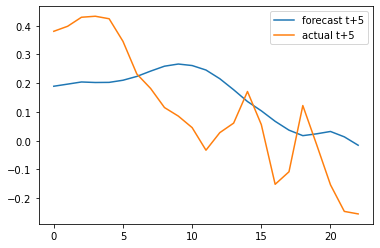

In [48]:
#Plotting lstm_2_prediction forecast types against actual conditions - ALL SCALED STILL

#plt.plot(lstm_2_predictions_t1, label = 'forecast t+1')
plt.plot(lstm_2_predictions_t5, label = 'forecast t+5')
#plt.plot(y_test_2D_scaled[:, 0], label = 'actual t+1')
plt.plot(y_test_2D_scaled[:, 4], label = 'actual t+5')

plt.legend()
plt.show()

[[260.23486 260.13013 259.78265 259.8895  256.9484 ]
 [260.63907 260.5109  260.21753 260.29904 257.37012]
 [261.05576 260.91983 260.6722  260.72745 257.79858]
 [260.99384 260.89682 260.6114  260.67188 257.695  ]
 [261.02664 260.94485 260.65268 260.71344 257.71887]
 [261.3694  261.27216 261.0483  261.095   258.1436 ]
 [262.01846 261.90378 261.78494 261.80466 258.9034 ]
 [262.9294  262.8001  262.81976 262.81265 259.9649 ]
 [263.86652 263.75766 263.84506 263.8263  260.94287]
 [264.3992  264.3676  264.40057 264.3984  261.37512]
 [264.28342 264.37262 264.24838 264.29047 261.07312]
 [263.6316  263.82318 263.48    263.58966 260.1788 ]
 [262.24762 262.54492 261.87827 262.07013 258.44513]
 [260.4418  260.8138  259.8089  260.05902 256.24777]
 [258.38873 258.75998 257.494   257.77454 253.9025 ]
 [256.62518 256.88528 255.52628 255.8064  252.04823]
 [254.56996 254.70753 253.26093 253.55167 249.957  ]
 [252.7001  252.67595 251.23645 251.53186 248.1939 ]
 [251.34515 251.12051 249.7999  250.08794 247.

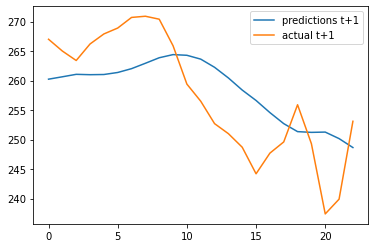

In [50]:
#Generating unscaled predictions. These are the ones to actually plot

lstm_2_predictions_unscaled = label_scaler.inverse_transform(lstm_2_predictions)
print(lstm_2_predictions_unscaled)

lstm_2_predictions_unscaled_t1 = lstm_2_predictions_unscaled[:, 0]
lstm_2_predictions_unscaled_t2 = lstm_2_predictions_unscaled[:, 1]
lstm_2_predictions_unscaled_t3 = lstm_2_predictions_unscaled[:, 2]
lstm_2_predictions_unscaled_t4 = lstm_2_predictions_unscaled[:, 3]
lstm_2_predictions_unscaled_t5 = lstm_2_predictions_unscaled[:, 4]

plt.plot(lstm_2_predictions_unscaled_t1, label = 'predictions t+1')
plt.plot(y_test_2D_unscaled[:, 0], label = 'actual t+1')
plt.legend()
plt.show()